In [6]:
import numpy as np
import tensorflow 
import os
import shutil
import itertools
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

# Downloading Mobile net

In [7]:
mobile_net = tensorflow.keras.applications.mobilenet.MobileNet()

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile_net.summary()

# Image preprocessing method

this method helps to get the img in the right format before passing it to the network for prediction

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# preprocess the image in the way that mobile_net expects
def prepare_image(file):
  img_path ='/content/drive/MyDrive/0-myComputerVisionProjects/mobile_net_test'
  img = image.load_img(img_path + file,target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array,axis=0)
  return tensorflow.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
  # preprocess_input : scales the pixels to be from -1 and 1

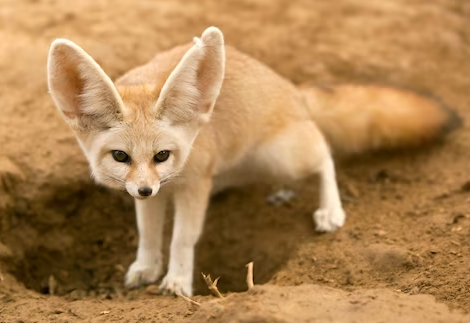

In [11]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/0-myComputerVisionProjects/mobile_net_test/fennec.png',width=300,height=200)

# Predicting with Mobile Net

In [17]:
preprocessed_image = prepare_image('/fennec.png')
predictions = mobile_net.predict(preprocessed_image)
# this keras method returns top 5 predictions from all the possible 1000 
results = imagenet_utils.decode_predictions(predictions)
results

1/1 [==============================] - 0s 72ms/step


[[('n02119789', 'kit_fox', 0.7449607),
  ('n02119022', 'red_fox', 0.14672785),
  ('n02115641', 'dingo', 0.052410256),
  ('n02114712', 'red_wolf', 0.010919408),
  ('n02120505', 'grey_fox', 0.010647323)]]

# Process our new data 

In [18]:
train_path = '/content/drive/MyDrive/dataset/face_mask_detection'
valid_path = ''
test_path = ''


preprocess data using preprocess_input function that scales the pixels to be from -1 to 1

In [41]:
train_batches = ImageDataGenerator( preprocessing_function = tensorflow.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=10,
    class_mode = 'categorical'
     )

Found 194 images belonging to 2 classes.


In [20]:
train_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [40]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [ ]:
valid_batches = ImageDataGenerator( preprocessing_function = tensorflow.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    valid_path,
    target_size=(224,224),
    batch_size=10
     )

In [ ]:
test_batches = ImageDataGenerator( preprocessing_function = tensorflow.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=10,
    shuffle=False
     )

# Fine tuning MobileNet to classify mask/noMask

# Viewing MobileNet architecture

In [42]:
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

we're going to grab the output from the fifth to last layer of the model and store it in this variable x.

In [55]:
x = mobile_net.layers[-5].output

We'll be using this to build a new model. This new model will consist of the original MobileNet up to the fifth to last layer. We're not including the last four layers of the original MobileNet.

By looking at the summary of the original model, we can see that by not including the last four layers, we'll be including everything up to and including the last global_average_pooling layer.

Now, we need to reshape our output from the global_average_pooling layer that we will pass to our output layer, which we're calling output. The output layer will just be a Dense layer with 2 output nodes for the 2 corresponding classes, and we'll use the softmax activation function.

In [56]:
x = tensorflow.keras.layers.Reshape(target_shape=(1024,))(x)

In [57]:
output_layer = Dense(units=2, activation='softmax')(x)

Now, we construct the new fine-tuned model, which we're calling model.

Note, you can see by the Model constructor used to create our model, that this is a model that is being created with the Keras Functional API, not the Sequential API that we've worked with in previous episodes. That's why this format that we're using to create the model may look a little different than what you're used to.

To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original MobileNet, and then we define the outputs of the model to be equal to the output variable we created directly above.

In [58]:
model = Model(inputs = mobile_net.input, outputs = output_layer)

# Freezing the previous layers 

In [59]:
# we want only yhe 23 last layers to be trainable
for layer in model.layers[:-23]:
  layer.trainable = False

So the twenty-third-to-last layer and all layers after it will be trained when we fit the model on the new data set.

In [60]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

# Training

In [61]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [62]:
model.fit(x=train_batches,epochs=10)

Epoch 1/10
20/20 [==============================] - 44s 2s/step - loss: 0.6062 - accuracy: 0.6443
Epoch 2/10
20/20 [==============================] - 8s 377ms/step - loss: 0.4315 - accuracy: 0.8247
Epoch 3/10
20/20 [==============================] - 9s 476ms/step - loss: 0.3256 - accuracy: 0.8918
Epoch 4/10
20/20 [==============================] - 8s 419ms/step - loss: 0.2525 - accuracy: 0.9381
Epoch 5/10
20/20 [==============================] - 9s 420ms/step - loss: 0.2019 - accuracy: 0.9536
Epoch 6/10
20/20 [==============================] - 9s 474ms/step - loss: 0.1665 - accuracy: 0.9691
Epoch 7/10
20/20 [==============================] - 8s 408ms/step - loss: 0.1397 - accuracy: 0.9794
Epoch 8/10
20/20 [==============================] - 9s 434ms/step - loss: 0.1210 - accuracy: 0.9897
Epoch 9/10
20/20 [==============================] - 10s 485ms/step - loss: 0.1044 - accuracy: 1.0000
Epoch 10/10
20/20 [==============================] - 8s 388ms/step - loss: 0.0916 - accuracy: 1.0000


# Classify new instance

In [64]:
train_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [63]:
model.predict(prepare_image('/gigi.jpg'))

1/1 [==============================] - 1s 531ms/step


array([[0.09806424, 0.90193576]], dtype=float32)